# Validate BayesFlow Posterior with MCMC

In this notebook we are going to validate the posterior from BayesFlow by comparing it to posteriors generated from MCMC.

In [1]:
import os
from functools import partial
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import pypesto.engine
from numba import njit
from pypesto import sample, optimize, visualize, FD, Objective, Problem, store
from scipy import stats
from tqdm import tqdm
from inference.likelihoods import log_likelihood_additive_noise, log_likelihood_multiplicative_noise

In [2]:
# specify which model to use
model_name = 'dePillis'
# this is needed so julia is recognized correctly
from juliacall import Main as jl

network_idx = 0
load_best_network = True

## Load individual model


In [3]:
presimulation_path = '../data/'

if model_name == 'fröhlich-simple':
    from models.froehlich_model_simple import FroehlichModelSimple, batch_simulator
    model = FroehlichModelSimple(network_idx=network_idx, load_best=load_best_network)

    use_presimulation = False
elif model_name == 'fröhlich-detailed':
    from models.froehlich_model_detailed import FroehlichModelDetailed, batch_simulator
    model = FroehlichModelDetailed(network_idx=network_idx, load_best=load_best_network)

    use_presimulation = True
    presimulation_path += 'presimulations_froehlich_detailed'

elif model_name == 'fröhlich-sde':
    from models.froehlich_model_sde import FroehlichModelSDE, batch_simulator
    model = FroehlichModelSDE(network_idx=network_idx, load_best=load_best_network)

    use_presimulation = True
    presimulation_path += 'presimulations_froehlich_sde'

elif model_name == 'pharmacokinetic_model':
    from models.pharmacokinetic_model import PharmacokineticModel, batch_simulator, convert_bf_to_observables
    model = PharmacokineticModel(network_idx=network_idx, load_best=load_best_network)

    use_presimulation = True
    presimulation_path += 'presimulations_pharma'

elif model_name == 'dePillis':
    from models.de_pillis_model import dePillisModel, batch_simulator, simulate_single_patient, convert_bf_to_observables
    model = dePillisModel(network_idx=network_idx, load_best=load_best_network)

    use_presimulation = True
    presimulation_path += 'presimulations_de_pillis'
else:
    raise NotImplementedError('model not implemented')

# load network
trainer = model.build_trainer('../networks/' + model.network_name)

/Users/jonas.arruda/miniconda/envs/Amortized-NLME/lib/python3.10/site-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
  Activating project at `~/PyCharm Projects/Amortized-NLME-Models/models/SimulatorDePillis`


using 2 layers of MultiConv1D, a bidirectional LSTM with 32 units and a dense layer with output dimension 18 as summary network
using a 8-layer cINN as inference network with 2 layers of design spline
Using normal prior adapted for dePillis
prior mean: [  2.30258509  -4.60517019  -0.43078292 -13.81551056 -13.81551056
   2.30258509   4.00733319   0.          -2.30258509]
prior covariance diagonal: [10.  16.   0.5 16.   3.   0.2  0.2  1.   0.6]
Using the model dePillisModel


INFO:root:Performing 2 pilot runs with the dePillisModel model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 9)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 7, 6)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:Loaded loss history from ../networks/amortizer-dePillis-normal-sequence-summary-Bi-LSTM-2-conv-layers-8layers-2coupling-spline-normal-300epochs-wide/history_295.pkl.
INFO:root:Networks loaded from ../networks/amortizer-dePillis-normal-sequence-summary-Bi-LSTM-2-conv-layers-8layers-2coupling-spline-normal-300epochs-wide/ckpt-295
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


Networks loaded from ../networks/amortizer-dePillis-normal-sequence-summary-Bi-LSTM-2-conv-layers-8layers-2coupling-spline-normal-300epochs-wide/ckpt-294
Validation loss: 1.9461
Model: "amortized_posterior"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 invertible_network (Invert  multiple                  768224    
 ibleNetwork)                                                    
                                                                 
 sequence_network (Sequence  multiple                  25746     
 Network)                                                        
                                                                 
Total params: 793970 (3.03 MB)
Trainable params: 793970 (3.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


## Load Data

100%|██████████| 100/100 [00:07<00:00, 12.97it/s]
/Users/jonas.arruda/miniconda/envs/Amortized-NLME/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.canvas.print_figure(bytes_io, **kw)


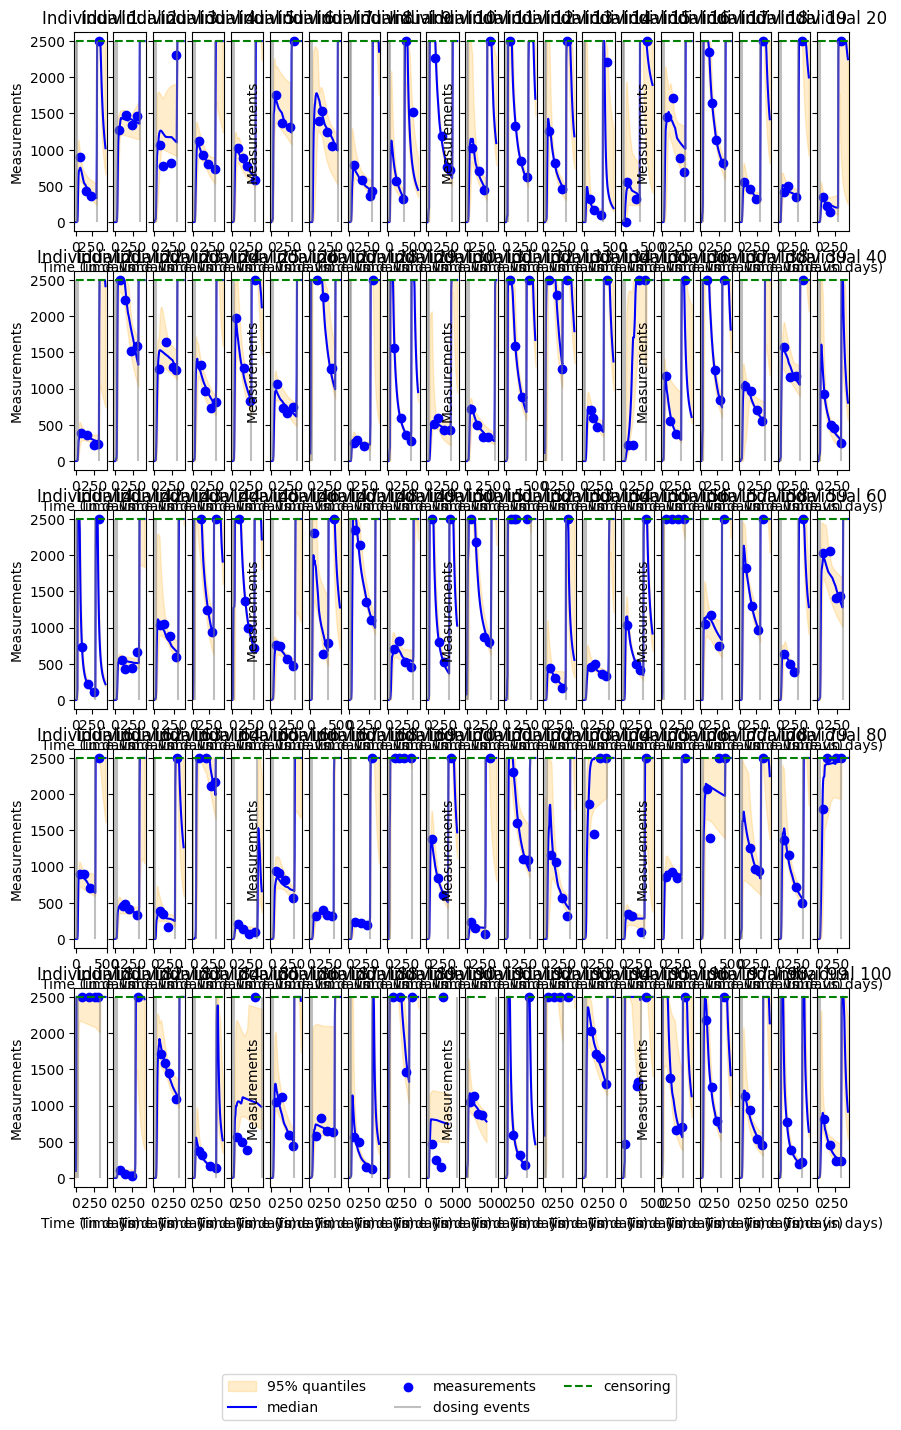

In [4]:
# load real data (here for the first time), simulate posterior and plot
test_data = model.load_data(n_data=100, synthetic=False)  # or load synthetic data with synthetic=True
data_posterior_draws = model.draw_posterior_samples(data=test_data, n_samples=10)

rows = 5
fig, ax = plt.subplots(rows, int(np.ceil(len(test_data) / rows)), tight_layout=True,
                       figsize=(10, rows*3), sharey='row')
axis = ax.flatten()

for p_id in tqdm(range(len(test_data))):
    axis[p_id] = model.prepare_plotting(test_data[p_id], data_posterior_draws[p_id], axis[p_id])
    _, labels = axis[p_id].get_legend_handles_labels()
    axis[p_id].set_title(f'Individual {p_id+1}')
    if p_id % rows != 0:
        axis[p_id].set_ylabel('')

fig.legend(labels, ncol=3, loc='upper center', bbox_to_anchor=(0.5, -0.01))
plt.show()

## Prepare MCMC Posterior

First we need to define the likelihood and the prior we want to use for MCMC.
Note: BayesFlow works without specifying a likelihood since it is a simulation-based method.

In [6]:
@njit
def log_prior_density_normal(log_param: np.ndarray, 
                             mean: np.ndarray,
                             inv_cov_matrix: np.ndarray, 
                             prior_constant: float) -> float:
    # compute the log normal density of the prior
    dif = log_param - mean
    return prior_constant - 0.5 * dif.dot(inv_cov_matrix).dot(dif.T) # - log_param.sum()  sum cancels with log-transformation

@njit
def log_prior_density_uniform(log_param: np.ndarray, 
                              prior_bounds: np.ndarray) -> float:
    # check if parameters are within bounds
    if np.any(log_param < prior_bounds[:, 0]) or np.any(log_param > prior_bounds[:, 1]):
        return -np.inf
    # compute the log uniform density of the prior
    constant = -np.log(np.diff(prior_bounds).prod())
    return constant

if model.prior_type == 'normal':
    _, logabsdet = np.linalg.slogdet(model.prior_cov)
    log_prior_constant = -0.5 * model.n_params * np.log(2 * np.pi) -0.5* logabsdet
    inv_cov = np.linalg.inv(model.prior_cov)

In [7]:
individual_id = 0
obs_data_indv = test_data[individual_id]

In [8]:
# prepare simulator accordingly to the model
if 'Froehlich' in model.name :
    # prepare simulator, data should be on log-scale
    simulator = partial(batch_simulator, 
                                n_obs=180,
                                with_noise=False)
    noise_model = 'multiplicative'  # additive on log-scale 
    index_sigma = -1  # index of sigma in parameter vector
    obs_data_indv_prepared = obs_data_indv.flatten()  # just one measurement per time point, already on log-scale
elif 'Pharma' in model.name:
    # prepare simulator, data should be on log-scale
    obs_data_indv_prepared, t_measurement, doses_time_points, dos, wt = convert_bf_to_observables(obs_data_indv)
    simulator = partial(batch_simulator,
                       t_measurement=t_measurement,
                       t_doses=doses_time_points,
                       wt=wt,
                       dos=dos,
                       with_noise=False,
                       convert_to_bf_batch=False)
    noise_model = 'multiplicative'  # additive on log-scale
    index_sigma = [-3, -2]  # index of sigmas in parameter vector
elif 'dePillis' in model.name:
    # prepare simulator, data should be on log-scale
    obs_data_indv_prepared, t_measurements, doses_time_points, infected_before_first_dose = convert_bf_to_observables(obs_data_indv)
    simulator = partial(simulate_single_patient,
                       patient_data=obs_data_indv,
                       with_noise=False)
    noise_model = 'proportional'  # additive on linear-scale
    index_sigma = [-2, -1]  # index of sigmas in parameter vector
else:
    raise NotImplementedError('model not implemented')

assert simulator(model.prior_mean).shape == obs_data_indv_prepared.shape, 'simulator output shape does not match data shape'

In [9]:
def neg_log_likelihood(log_param: np.ndarray):
    y_sim = simulator(log_param)  
    if noise_model == 'multiplicative':
        llh = log_likelihood_multiplicative_noise(log_measurements=obs_data_indv_prepared,
                                                  log_simulations=y_sim,
                                                  sigmas=np.exp(log_param[index_sigma]))
    else:  # noise_model == 'proportional':
        prop_sigma = np.exp(log_param[index_sigma[0]]) + obs_data_indv_prepared * np.exp(log_param[index_sigma[1]])
        #prop_sigma = obs_data_indv_prepared * np.exp(log_param[index_sigma])
        llh = log_likelihood_additive_noise(measurements=obs_data_indv_prepared,
                                            simulations=y_sim,
                                            sigmas=prop_sigma)
    return -llh

## Run MCMC

In [10]:
from pypesto.objective import NegLogParameterPriors, AggregatedObjective, Objective
from pypesto.objective.priors import get_parameter_prior_dict

n_chains = 10
filename = f'../Experiments/dePillis/mcmc_individual_{individual_id}_real.hdf5'

prior_list = [get_parameter_prior_dict(index=i,
                         prior_type="parameterScaleNormal",
                         prior_parameters=[model.prior_mean[i], model.prior_std[i]],
                         parameter_scale="log")
     for i in range(1, model.n_params)]
if infected_before_first_dose == 1:
   prior_list = [get_parameter_prior_dict(index=0,
                         prior_type="parameterScaleNormal",
                         prior_parameters=[model.prior_mean[0], model.prior_std[0]],
                         parameter_scale="log")] + prior_list

prior = NegLogParameterPriors(prior_list)

# create pypesto problem
pesto_problem = Problem(objective=Objective(neg_log_likelihood), #AggregatedObjective([Objective(neg_log_likelihood), prior]),
                        lb=model.prior_mean - 4 * model.prior_std,
                        ub=model.prior_mean + 4 * model.prior_std,
                        #x_guesses=[params[individual_id]],
                        x_names=model.log_param_names,
                        x_fixed_vals=None if infected_before_first_dose == 1 else [np.log(0.01)],
                        x_fixed_indices=None if infected_before_first_dose == 1 else [0],
                        #x_priors_defs=prior,
                        x_scales=['log']*len(model.log_param_names)
                        )
pesto_problem.print_parameter_summary()

                    free    lb_full    ub_full
$\log$ Ab0         False -10.346526  14.951696
$\log$ r1           True -20.605170  11.394830
$\log$ r2           True  -3.259210   2.397644
$\log$ r3           True -29.815511   2.184489
$\log$ r4           True -20.743714  -6.887307
$\log$ k1           True   0.513731   4.091439
$\log$ k2           True   2.218479   5.796188
$\log$ error_lin    True  -4.000000   4.000000
$\log$ error_prop   True  -5.400972   0.795802


In [11]:
# check if file exists, if not run optimization
if False: #os.path.exists(filename):
    result = store.read_result(filename)
    result.problem = pesto_problem
else:
    result = optimize.minimize(
        problem=pesto_problem,
        n_starts=n_chains
    )

100%|██████████| 10/10 [00:26<00:00,  2.67s/it]


In [12]:
result.optimize_result.x[0]

array([ -4.60517019,  -8.91594165,  -0.14504973,  -5.10000409,
       -10.66987938,   0.51373071,   2.68420471,  -3.97024987,
        -3.9792004 ])

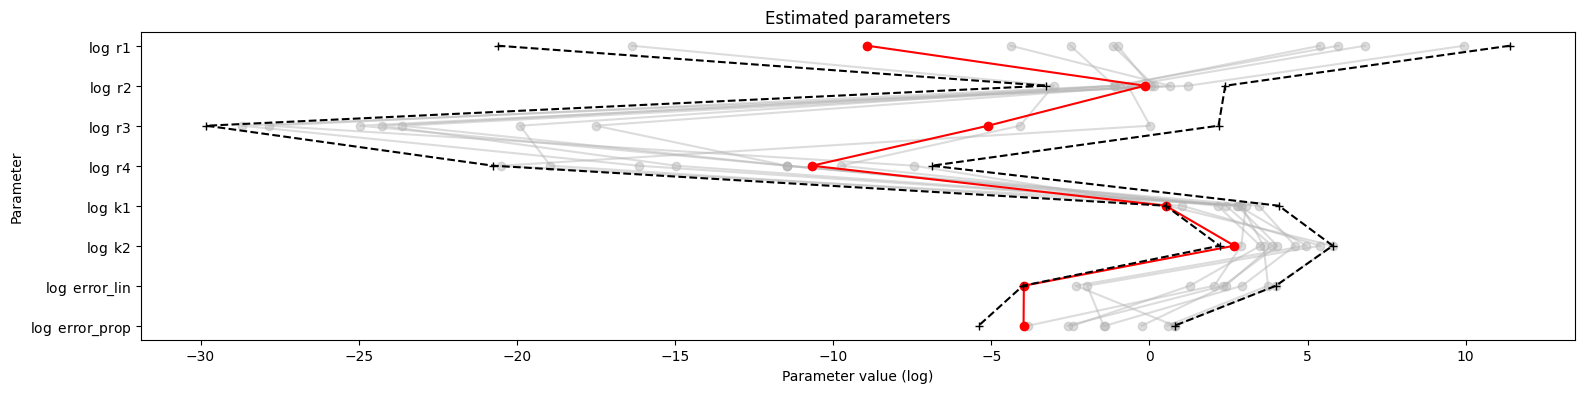

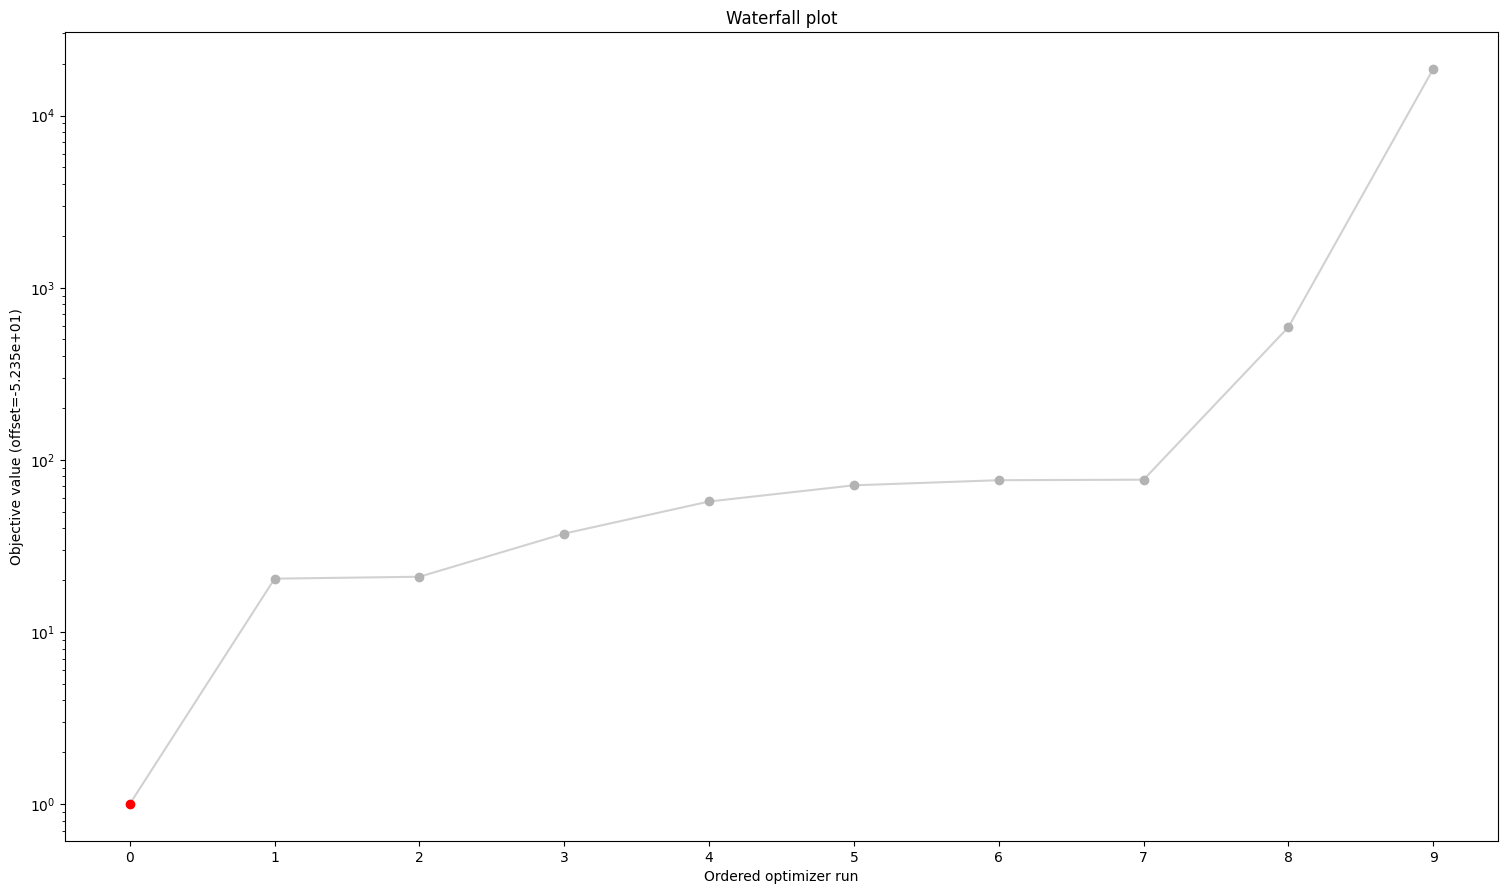

In [13]:
visualize.parameters(result)
visualize.waterfall(result);

100%|██████████| 6/6 [00:00<00:00, 74.66it/s]


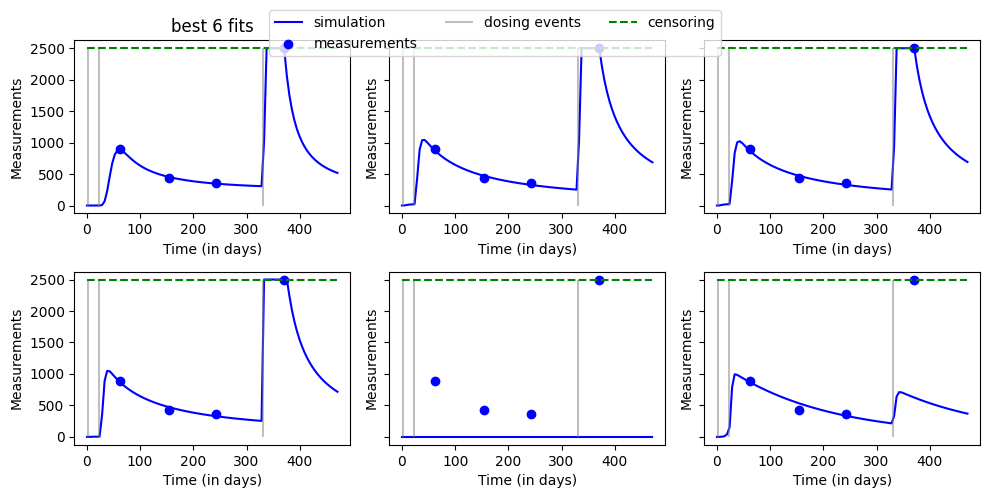

In [14]:
fig, ax = plt.subplots(2, 3, tight_layout=True, figsize=(10, 5),
                       sharex='row', sharey='all')
axis = ax.flatten()
    
for p_id in tqdm(range(axis.size)):
    axis[p_id] = model.prepare_plotting(obs_data_indv, result.optimize_result.x[p_id], axis[p_id])
    _, labels = axis[p_id].get_legend_handles_labels()

fig.legend(labels, ncol=3, loc='upper center', bbox_to_anchor=(0.5, 1))
axis[0].set_title(f'best {axis.size} fits')
plt.show()

In [ ]:
sampler = sample.AdaptiveParallelTemperingSampler(
    internal_sampler=sample.AdaptiveMetropolisSampler(), n_chains=n_chains,
)

In [ ]:
if True: #not os.path.exists(filename):
    result = sample.sample(
        pesto_problem,
        n_samples=1000,
        sampler=sampler,
        filename=filename,
        result=result,
        overwrite=True
    )

In [ ]:
geweke_test = sample.geweke_test(result)
auto_correlation = sample.auto_correlation(result)
effective_sample_size = sample.effective_sample_size(result)

In [ ]:
visualize.sampling_parameter_traces(result);

In [ ]:
visualize.sampling_fval_traces(result);

In [ ]:
pesto_samples = result.sample_result.trace_x[0]
print(pesto_samples.shape)

In [ ]:
burn_in = result.sample_result.burn_in
pesto_samples_adjusted = np.array([pesto_problem.get_full_vector(p, pesto_problem.x_fixed_vals) for p in pesto_samples[burn_in:]])
print(pesto_samples_adjusted.shape)

In [ ]:
MAP_idx = np.argmin(result.sample_result.trace_neglogpost[0,burn_in:])
MAP = pesto_samples_adjusted[MAP_idx]
print('MAP (optimizing)', pesto_problem.objective(pesto_problem.get_reduced_vector(result.optimize_result.x[0])))
print('MAP (sampling)',  pesto_problem.objective(pesto_problem.get_reduced_vector(MAP)))

In [ ]:
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(10, 5))

ax = model.prepare_plotting(obs_data_indv, MAP, ax)
_, labels = ax.get_legend_handles_labels()
fig.legend(labels, ncol=4, loc='lower center', bbox_to_anchor=(0.5, 1))

ax.set_title(f'MAP fit')
plt.show()

# Compare BayesFlow and MCMC

In [ ]:
colors = ['#1f78b4', '#a6cee3', '#b2df8a','#33a02c','#fb9a99']

In [ ]:
# reduce to same number of samples
n_samples = min(data_posterior_draws[individual_id].shape[0], pesto_samples_adjusted.shape[0])
bayes_flow_samples = data_posterior_draws[individual_id]
mcmc_smaples = pesto_samples_adjusted

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=int(np.ceil(model.n_params/2)), tight_layout=True, figsize=(12,6))
axis = ax.flatten()
bins = 20
binwidth = 0.5
xlim = np.stack((pesto_problem.lb_full, pesto_problem.ub_full)).T
    
for i, name in enumerate(model.param_names):
    axis[i].set_title(name) #'log '+name)
    axis[i].hist(bayes_flow_samples[:, i],
                 bins=np.linspace(xlim[i][0], xlim[i][1], bins), #bins,
                 density=True, label='BayesFlow', color='#d7191c') #
    ylim = axis[i].get_ylim()
    #xlim = axis[i].get_xlim()

    axis[i].hist(mcmc_smaples[:, i],
                 bins=np.linspace(xlim[i][0], xlim[i][1], bins),
                 #bins=np.arange(min(np.exp(mcmc_smaples[:, i])), max(np.exp(mcmc_smaples[:, i])) + binwidth, binwidth),
                 density=True, label='MCMC', alpha=0.6, color='#2c7bb6')
    axis[i].set_ylim(ylim)
    
    
    if model.prior_type == 'normal':
        #x_prior = np.linspace(model.prior_mean[i] - 0.1*model.prior_std[i], 
         #           model.prior_mean[i] + 0.1*model.prior_std[i], 1000)
        #prior_density = stats.norm.pdf(x_prior, model.prior_mean[i], model.prior_std[i])
        #prior_handle, = axis[i].plot(np.exp(x_prior), prior_density, color='orange', label='Prior',
        #                             linestyle='-')
        # set axis to lim without prior 
        pass #axis[i].set_xlim(xlim)
    elif model.prior_type == 'uniform':
        axis[i].set_xlim(model.prior_bounds[i])
     
    #true_value = axis[i].axvline(params[individual_id][i], linestyle='--', color='black',
    #                             label='true parameter')
    
    true_param = params[individual_id][i]
    #xlim = true_param -0.5*true_param, true_param+0.5*true_param
    #xlim = -1, np.exp(cell_param_log.values[individual_id][i])+1
    axis[i].set_xlim(xlim[i])
    
bf_handle = mpatches.Patch(color='#d7191c', label='BayesFlow')
mcmc_handle = mpatches.Patch(color='#2c7bb6', label='MCMC')
#lgd = fig.legend(handles=[bf_handle, mcmc_handle, true_value], ncol=3, loc='lower center', bbox_to_anchor=(0.5, -0.05))
lgd = fig.legend(handles=[bf_handle, mcmc_handle], ncol=3, loc='lower center', bbox_to_anchor=(0.5, -0.05))

for _ax in axis[model.n_params:]:
    _ax.remove()
plt.show()

In [ ]:
sim_data = simulator(data_posterior_draws[individual_id])
sim_data_MCMC = simulator(mcmc_smaples)

In [ ]:
sim_data = np.median(sim_data, axis=0)
sim_data.sort()
sim_data_MCMC = np.median(sim_data_MCMC, axis=0)
sim_data_MCMC.sort()

In [ ]:
fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(16, 6),
                       sharex='row', sharey='all')
    
ax[0] = model.prepare_plotting(obs_data_indv, data_posterior_draws[individual_id], ax[0], with_noise=False)
ax[1] = model.prepare_plotting(obs_data_indv, mcmc_smaples, ax[1], with_noise=False)
_, labels = ax[0].get_legend_handles_labels()
ax[1].set_ylabel('')

fig.legend(labels, ncol=3, loc='lower center', bbox_to_anchor=(0.5, -0.01))
ax[0].set_title('BayesFlow Posterior Predictive')
ax[1].set_title('MCMC Posterior Predictive')
plt.show()